In [7]:
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})

# 종목정보 데이터 분석

먼저 거래소를 통해 수집한 산업별 현황과 개별지표를 정리한 파일, WICS 기준 섹터 지표를 정리한 파일을 통해 국내 상장종목의 데이터를 분석해보겠습니다.

In [13]:
code_template = '{0:06d}'
KOR_ticker = pd.read_csv('data/KOR_ticker.csv', encoding='cp949')
KOR_ticker['종목코드'] = KOR_ticker['종목코드'].apply(lambda x: code_template.format(x))
KOR_sector = pd.read_csv('data/KOR_sector.csv', encoding='cp949')
KOR_sector['CMP_CD'] = KOR_sector['CMP_CD'].apply(lambda x: code_template.format(x))

data_market = pd.merge(KOR_ticker, KOR_sector, how='left', left_on=['종목코드', '종목명'], right_on=['CMP_CD', 'CMP_KOR'])
data_market = data_market.drop(['CMP_CD', 'CMP_KOR'], axis=1)
data_market.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2268 entries, 0 to 2267
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   종목코드         2268 non-null   object 
 1   종목명          2268 non-null   object 
 2   시장구분         2268 non-null   object 
 3   업종명          2268 non-null   object 
 4   종가           2268 non-null   int64  
 5   대비           2268 non-null   int64  
 6   등락률          2268 non-null   float64
 7   시가총액         2268 non-null   int64  
 8   EPS          1586 non-null   float64
 9   PER          1586 non-null   float64
 10  선행 EPS       567 non-null    float64
 11  선행 PER       567 non-null    float64
 12  BPS          2258 non-null   float64
 13  PBR          2258 non-null   float64
 14  주당배당금        2268 non-null   int64  
 15  배당수익률        2268 non-null   float64
 16  IDX_CD       2176 non-null   object 
 17  IDX_NM_KOR   2176 non-null   object 
 18  ALL_MKT_VAL  2176 non-null   float64
 19  MKT_VA

In [14]:
# 섹터
data_market['SEC_NM_KOR'].unique()

array(['IT', '건강관리', '소재', '커뮤니케이션서비스', '경기관련소비재', '산업재', '금융', '에너지',
       '유틸리티', '필수소비재', nan], dtype=object)

In [55]:
data_market['SEC_NM_KOR'].value_counts()

IT           596
경기관련소비재      352
산업재          351
건강관리         293
소재           229
커뮤니케이션서비스    115
필수소비재        103
금융            84
에너지           36
유틸리티          17
Name: SEC_NM_KOR, dtype: int64

In [56]:
data_market['업종명'].value_counts()

화학             190
반도체            122
기계·장비          110
제약             109
IT부품           108
기타서비스          104
소프트웨어           91
유통              91
서비스업            75
일반전기전자          70
의료·정밀기기         69
기타금융            65
운송장비·부품         63
금속              62
유통업             62
전기전자            61
운수장비            60
통신장비            51
철강금속            49
의약품             46
디지털컨텐츠          42
기계              41
음식료·담배          39
음식료품            37
금융              32
오락·문화           30
건설              29
건설업             28
컴퓨터서비스          25
운수창고업           25
출판·매체복제         25
섬유의복            24
비금속광물           23
정보기기            21
증권              19
종이목재            18
섬유·의류           18
기타제조업           15
기타제조            14
비금속             13
보험              12
인터넷             10
종이·목재           10
전기가스업           10
통신서비스            9
의료정밀             8
방송서비스            8
농업, 임업 및 어업      6
운송               5
통신업              4
은행               3
숙박·음식            3
광업          

In [24]:
# 열 생성
data_market['ROE'] = round(data_market['PBR'] / data_market['PER'], 4)
data_market['size'] = 'small'
data_market['size'][data_market['시가총액'] >= data_market['시가총액'].median(skipna=True)] = 'big'
data_market[['종목명', 'ROE', 'size']]

,종목명,ROE,size
0,삼성전자,0.1324,big
1,LG에너지솔루션,0.0995,big
2,SK하이닉스,0.1548,big
3,삼성바이오로직스,0.0789,big
4,LG화학,0.1695,big
...,...,...,...
2263,에스디시스템,0.2178,small
2264,제이웨이,NaN,small
2265,케이프이에스제4호,NaN,small
2266,한국코퍼레이션,0.0948,small


In [25]:
# Filter
cond_1 = data_market['PBR'] < 1
cond_2 = data_market['PER'] < 20
cond_3 = data_market['ROE'] > 0.1

data_market[cond_1 & cond_2 & cond_3]

,종목코드,종목명,시장구분,업종명,종가,대비,등락률,시가총액,EPS,PER,...,WGT,S_WGT,CAL_WGT,SEC_CD,SEC_NM_KOR,SEQ,TOP60,APT_SHR_CNT,ROE,size
8,000270,기아,KOSPI,운수장비,76400,-900,-1.16,30969759710800,11874.0,6.43,...,15.51,35.05,1.0,G25,경기관련소비재,2.0,8.0,251325275.0,0.1369,big
11,005490,POSCO홀딩스,KOSPI,철강금속,242500,-8000,-3.19,21142807487500,87330.0,2.78,...,15.00,40.70,1.0,G15,소재,2.0,8.0,60158916.0,0.1295,big
26,003550,LG,KOSPI,기타금융,75600,-2000,-2.58,11891955070800,15504.0,4.88,...,4.58,25.42,1.0,G20,산업재,4.0,19.0,83369526.0,0.1168,big
27,086790,하나금융지주,KOSPI,기타금융,40000,-2200,-5.21,11836139040000,11819.0,3.38,...,9.30,37.44,1.0,G40,금융,3.0,8.0,263354094.0,0.1006,big
29,017670,SK텔레콤,KOSPI,통신업,52000,-600,-1.14,11379323488000,7191.0,7.23,...,5.24,62.13,1.0,G50,커뮤니케이션서비스,5.0,5.0,113793235.0,0.1355,big
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2209,011300,성안,KOSPI,섬유의복,533,2,0.38,30305239380,383.0,1.39,...,0.02,100.27,1.0,G25,경기관련소비재,321.0,8.0,39231923.0,0.6043,small
2223,054410,케이피티유,KOSDAQ,금속,5550,-150,-2.63,28083000000,1199.0,4.63,...,0.01,99.86,1.0,G15,소재,226.0,8.0,2479400.0,0.1598,small
2226,039740,한국정보공학,KOSDAQ,유통,3460,-240,-6.49,27743653620,523.0,6.62,...,0.00,99.41,1.0,G45,IT,586.0,2.0,4089382.0,0.1027,small
2259,033790,스카이문스테크놀로지,KOSDAQ,통신장비,829,0,0.00,14190075900,133.0,6.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1027,small


In [29]:
# 요약 통계
data_market['PBR'].describe()

count    2258.000000
mean        1.948211
std         2.805935
min         0.150000
25%         0.660000
50%         1.180000
75%         2.150000
max        50.960000
Name: PBR, dtype: float64

In [37]:
# 정렬
data_market[['종목명', '시가총액', 'ROE']].sort_values('ROE').dropna(subset=['ROE'], axis=0)

,종목명,시가총액,ROE
606,STX엔진,296814861600,0.0002
947,블루콤,172710000000,0.0004
696,아바텍,251280750000,0.0006
2057,서울전자통신,46763705184,0.0008
1245,FSN,118873391520,0.0010
...,...,...,...
1186,지투파워,126642782250,0.7541
1810,웨이브일렉트로,66921514320,0.7706
228,현대두산인프라코어,993588600750,0.8372
423,우리기술투자,435120000000,0.8462


In [54]:
# 순위 계산
data_market['PBR_rank'] =  data_market['PBR'].rank(method='min', ascending=True, na_option='keep')
data_market[['종목명', 'PBR', 'PBR_rank']].sort_values('PBR_rank', ascending=True)

,종목명,PBR,PBR_rank
139,한화생명,0.15,1.0
463,HDC,0.15,1.0
909,넥센,0.17,3.0
1055,대한화섬,0.17,3.0
1604,경동인베스트,0.18,5.0
...,...,...,...
2235,베스파,NaN,NaN
2261,아리온,NaN,NaN
2262,지나인제약,NaN,NaN
2264,제이웨이,NaN,NaN


In [53]:
# 순위 계산
data_market['ROE_rank'] =  data_market['ROE'].rank(method='min', ascending=False, na_option='keep')
data_market[['종목명', 'ROE', 'ROE_rank']].sort_values('ROE_rank', ascending=True)

,종목명,ROE,ROE_rank
309,F&F홀딩스,1.7143,1.0
423,우리기술투자,0.8462,2.0
228,현대두산인프라코어,0.8372,3.0
1810,웨이브일렉트로,0.7706,4.0
1186,지투파워,0.7541,5.0
...,...,...,...
2261,아리온,NaN,NaN
2262,지나인제약,NaN,NaN
2264,제이웨이,NaN,NaN
2265,케이프이에스제4호,NaN,NaN


In [60]:
import numpy as np
np.arange(0, 1, 5)

array([0])

In [62]:
list(range(0., 1., 0.1))

TypeError: 'float' object cannot be interpreted as an integer

In [92]:
# ntile 분위수 계산
n = 5

def ntile(data, n=5):
    step = 1/n
    data_copy = data.copy()
    # data_market[f'PBR_{n}_tile'] = None
    for r in range(n):
        left = data.quantile(r*step)
        right = data.quantile((r+1)*step)

        left_cond = data >= left
        right_cond = data < right

        data_copy[left_cond & right_cond] = r+1
    return data_copy

data_market['PBR_5_tile'] = ntile(data_market['PBR'], n=5)
data_market[['PBR', f'PBR_{n}_tile']]



,PBR,PBR_5_tile
0,1.32,3.0
1,10.07,5.0
2,1.02,3.0
3,10.96,5.0
4,1.99,4.0
...,...,...
2263,0.88,2.0
2264,NaN,NaN
2265,NaN,NaN
2266,0.38,1.0


# 시각화

## 산포도

Text(0, 0.5, 'PBR')

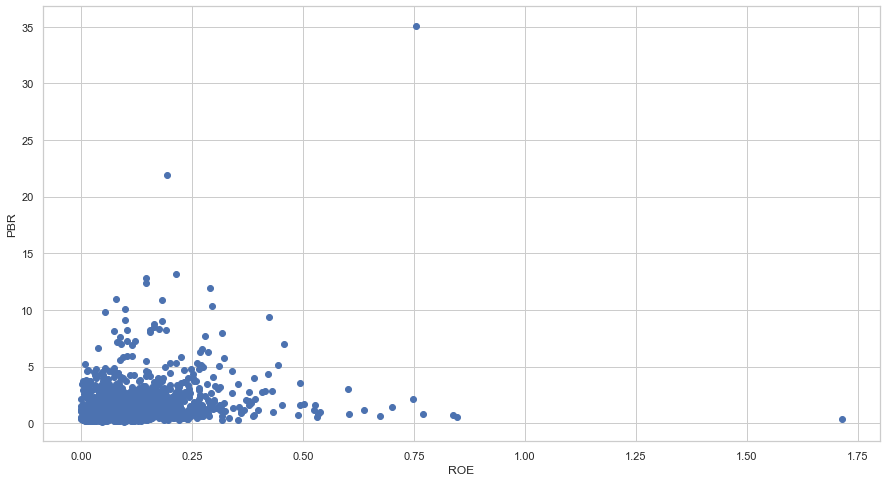

In [194]:
plt.scatter(data_market['ROE'], data_market['PBR'])
plt.xlabel('ROE'),
plt.ylabel('PBR')

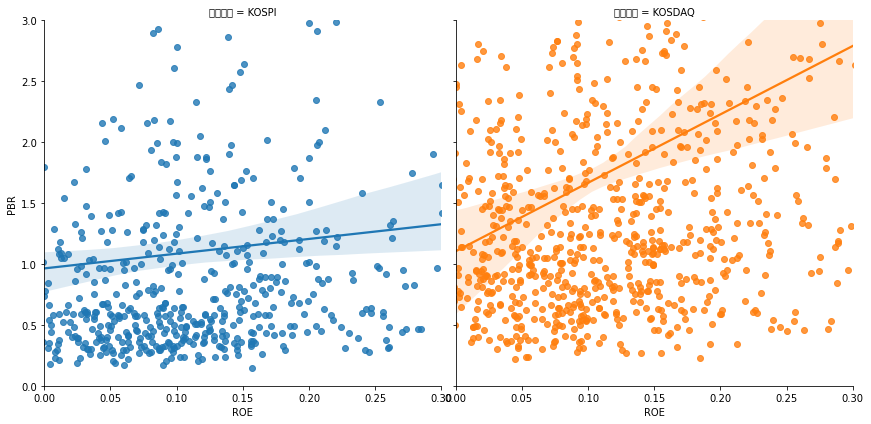

In [122]:
# sns.scatterplot(data_market['ROE'], data_market['PBR'])
g = sns.lmplot(data=data_market, x='ROE', y='PBR', hue='시장구분', col='시장구분', height=6, aspect=1, x_jitter=.1)
g.set(xlim=(0, 0.30), ylim=(0,3))
# sns.lmplot(data=data_market, x='ROE', y='PBR')

## 히스토그램

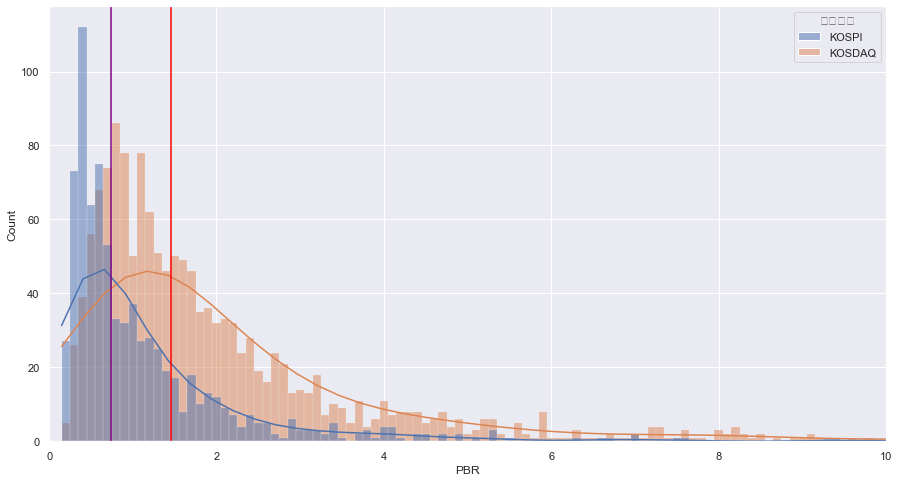

In [140]:
g = sns.histplot(data=data_market, x='PBR', binwidth=0.1, kde=True, hue='시장구분')
g.set(xlim=(0, 10))
plt.axvline(x=data_market[data_market['시장구분']=='KOSPI'].PBR.median(), color='purple')
plt.axvline(x=data_market[data_market['시장구분']=='KOSDAQ'].PBR.median(), color='red')

## 박스플롯

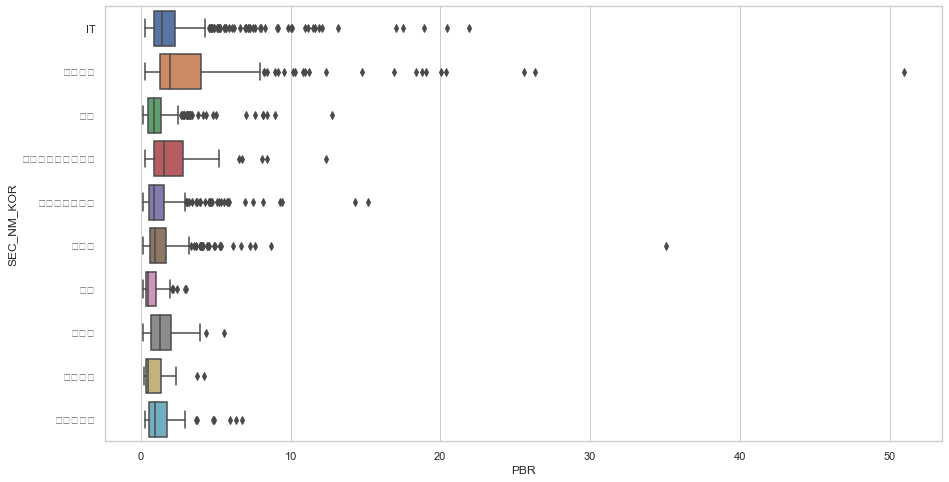

In [145]:
plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", 
rc={"axes.unicode_minus":False}, style='darkgrid')
sns.set_theme(style="whitegrid")
ax = sns.boxplot(data=data_market, x="PBR", y='SEC_NM_KOR')

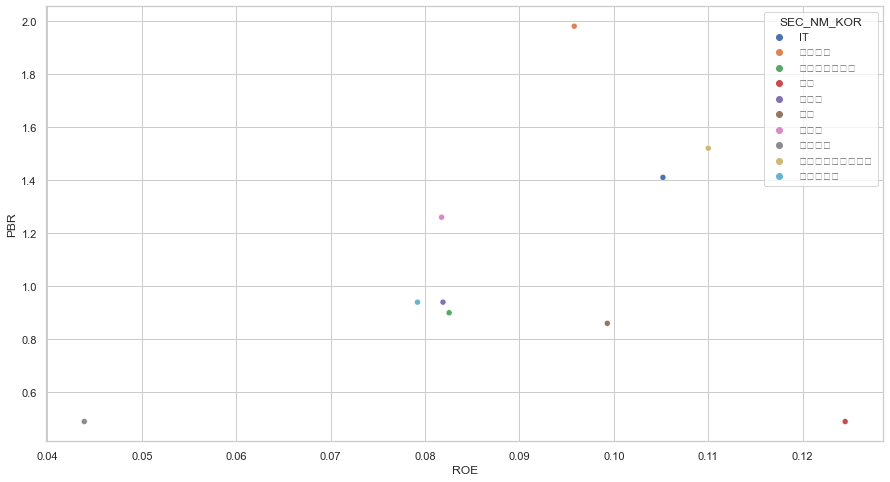

In [155]:
sector_summary = data_market[data_market['SEC_NM_KOR'].isna().apply(lambda x: not x)][['SEC_NM_KOR', 'ROE', 'PBR']].groupby('SEC_NM_KOR').median().reset_index()
g = sns.scatterplot(data=sector_summary, x='ROE', y='PBR', hue='SEC_NM_KOR')

<AxesSubplot:xlabel='sector', ylabel='count'>

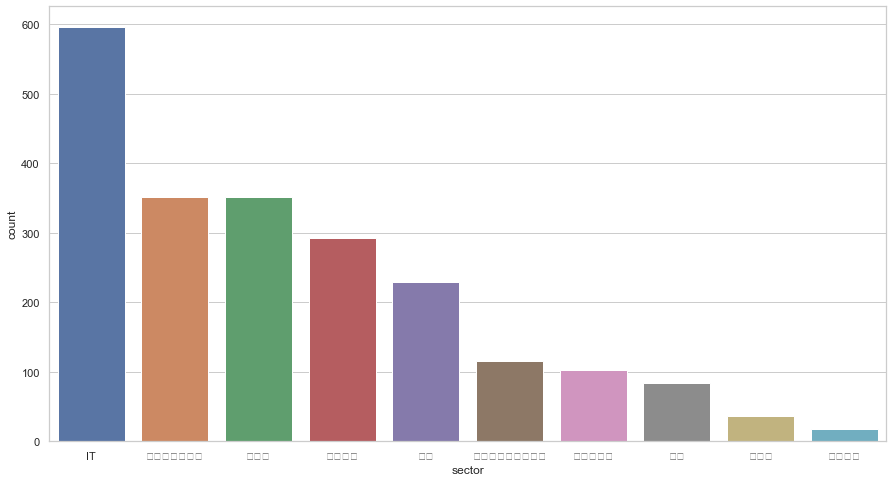

In [158]:
sns.barplot(
    data = data_market['SEC_NM_KOR'].value_counts().reset_index().rename(columns={'index': 'sector', 'SEC_NM_KOR': 'count'}),
    x='sector', y='count'
)

# 주가 시각화

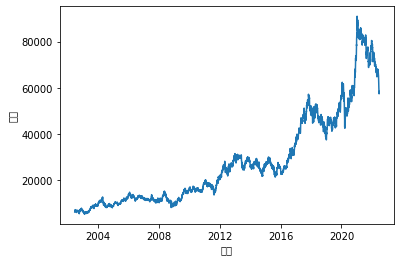

In [3]:
prices = pd.read_csv('data/KOR_price/005930_price.csv', encoding='cp949')
prices["날짜"] = pd.to_datetime(prices["날짜"], format = "%Y%m%d")
g = sns.lineplot(data=prices, x='날짜', y='종가')

# 연도별 수익률

In [4]:
year=2009
buy, sell = prices[pd.DatetimeIndex(prices['날짜']).year == year].iloc[[0, -1], 1].tolist()
buy, sell

(9400, 15980)

In [8]:
years = pd.DatetimeIndex(prices['날짜']).year.unique()
ret_yearly = pd.DataFrame({'year': years, 'return': [None]*len(years)})
ret_yearly = ret_yearly.set_index('year')

for year in years:
    buy, sell = prices[pd.DatetimeIndex(prices['날짜']).year == year].iloc[[0, -1], 1].tolist()
    rt_year = round((sell-buy)/buy, 4)
    ret_yearly.loc[year, 'return'] = rt_year

ret_yearly = ret_yearly.reset_index()
ret_yearly

,year,return
0,2002,0.0162
1,2003,0.4028
2,2004,0.0033
3,2005,0.4612
4,2006,-0.0698
5,2007,-0.1104
6,2008,-0.171
7,2009,0.7
8,2010,0.1731
9,2011,0.1044


<AxesSubplot:xlabel='year', ylabel='return'>

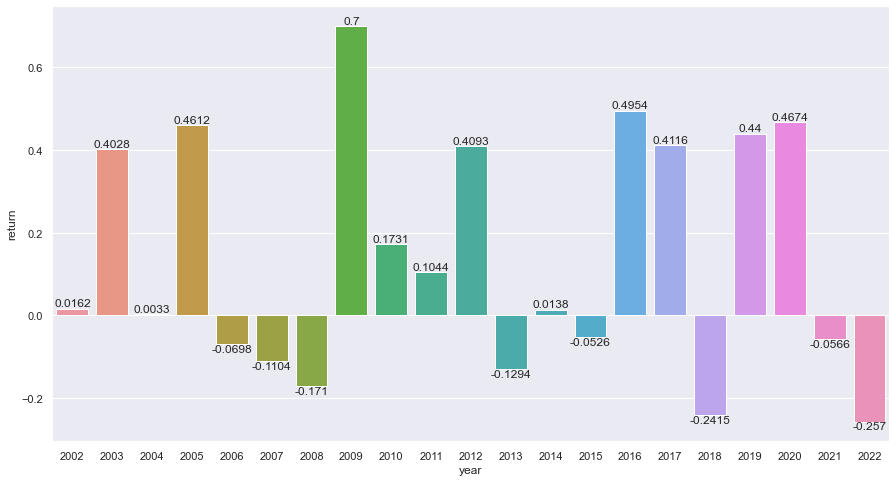

In [14]:
ax = sns.barplot(data=ret_yearly, x='year', y='return')
ax.bar_label(ax.containers[0])
ax